In [1]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=e60c485757a5a73b2e38b1e677770f57c89dd2fd1baaeeced3f6392ce318108e
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
import os, json, glob, re
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from datetime import datetime
import pickle

import tf_keras 
from transformers import AutoTokenizer, TFDistilBertForTokenClassification, create_optimizer
from seqeval.metrics import classification_report as seq_report
from seqeval.metrics import f1_score as seq_f1
from seqeval.metrics import accuracy_score as seq_acc
from seqeval.metrics import precision_score as seq_prec
from seqeval.metrics import recall_score as seq_rec

print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

2025-12-08 13:08:32.517198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765199312.716048      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765199312.765856      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

GPU Available: True


In [3]:
# 1. LOAD DATA (sama seperti kode asli)
base_path = "/kaggle/input"
json_paths = []

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".json"):
            json_paths.append(os.path.join(root, file))

print(f"📂 Ditemukan {len(json_paths)} file JSON.")

rows = []
for p in tqdm(json_paths, desc="Loading JSON"):
    try:
        with open(p, "r", encoding="utf-8") as f:
            j = json.load(f)
        anns = j.get("annotations", j.get("ann", []))
        rows.append({"text": j.get("text", ""), "ann": anns})
    except Exception as e:
        continue

df = pd.DataFrame(rows)
print(f"✅ Total Dokumen Valid: {len(df)}")

📂 Ditemukan 5029 file JSON.


Loading JSON:   0%|          | 0/5029 [00:00<?, ?it/s]

✅ Total Dokumen Valid: 5029


In [4]:
# 2. BIO TAGGING
def create_bio_tags(text, annotations):
    tokens = text.split()
    labels = ["O"] * len(tokens)
    token_spans = []
    current_idx = 0
    
    for token in tokens:
        start = text.find(token, current_idx)
        end = start + len(token)
        token_spans.append((start, end))
        current_idx = end

    for start_char, end_char, label in annotations:
        for i, (tok_start, tok_end) in enumerate(token_spans):
            if tok_start >= start_char and tok_end <= end_char:
                labels[i] = "B-SKILL" if tok_start == start_char else "I-SKILL"
    return tokens, labels

data_bio = []
for idx, row in df.iterrows():
    ts, ls = create_bio_tags(row['text'], row['ann'])
    if len(ts) > 0:
        data_bio.append({"tokens": ts, "tags": ls})

df_bio = pd.DataFrame(data_bio)
tag2idx = {"O": 0, "B-SKILL": 1, "I-SKILL": 2}
num_tags = len(tag2idx)
print(f"✅ Data siap format BIO. Jumlah sampel: {len(df_bio)}")

✅ Data siap format BIO. Jumlah sampel: 4982


In [5]:
# 3. DATA PREPARATION UNTUK DISTILBERT
model_name = 'distilbert-base-uncased'
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)

def tokenize_align(tokens_list, tags_list, max_length=128):
    input_ids, attention, labels = [], [], []
    for doc, tag in zip(tokens_list, tags_list):
        clean_w = [str(w).strip() for w in doc if str(w).strip()]
        clean_t = [t for w, t in zip(doc, tag) if str(w).strip()]
        if not clean_w: continue
        try:
            tok = tokenizer_bert(clean_w, is_split_into_words=True, truncation=True, 
                                padding='max_length', max_length=max_length)
        except: continue
        
        word_ids = tok.word_ids()
        label_ids = []
        prev_idx = None
        for wid in word_ids:
            if wid is None: label_ids.append(-100)
            elif wid != prev_idx: label_ids.append(tag2idx.get(clean_t[wid], 0))
            else: label_ids.append(-100)
            prev_idx = wid
            
        input_ids.append(tok['input_ids'])
        attention.append(tok['attention_mask'])
        labels.append(label_ids)
        
    return ({
        'input_ids': tf.convert_to_tensor(input_ids), 
        'attention_mask': tf.convert_to_tensor(attention)
    }, tf.convert_to_tensor(labels))

# Split data
train_docs, temp_docs, train_tags, temp_tags = train_test_split(
    df_bio['tokens'].tolist(), df_bio['tags'].tolist(), test_size=0.3, random_state=42
)
val_docs, test_docs, val_tags, test_tags = train_test_split(
    temp_docs, temp_tags, test_size=0.5, random_state=42
)

print(f"\n📊 Data Split:")
print(f"  Train: {len(train_docs)} | Val: {len(val_docs)} | Test: {len(test_docs)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


📊 Data Split:
  Train: 3487 | Val: 747 | Test: 748


In [6]:
# 4. FUNGSI EVALUASI
def evaluate_model(model, dataset, tag_map, pad_value=-100):
    id2tag = {v: k for k, v in tag_map.items()}
    y_true_seq, y_pred_seq = [], []

    for batch in dataset:
        inputs, labels = batch
        logits = model.predict(inputs, verbose=0)
        preds_logits = logits.logits if hasattr(logits, 'logits') else logits
        probs = tf.nn.softmax(preds_logits, axis=-1).numpy()
        pred_ids = np.argmax(probs, axis=-1)
        labels_np = labels.numpy()
        
        for i in range(len(labels_np)):
            t_true, t_pred = [], []
            for j in range(len(labels_np[i])):
                lid = labels_np[i][j]
                if lid != pad_value and lid in id2tag:
                    t_true.append(id2tag[lid])
                    t_pred.append(id2tag[pred_ids[i][j]])
            if t_true:
                y_true_seq.append(t_true)
                y_pred_seq.append(t_pred)

    f1 = seq_f1(y_true_seq, y_pred_seq)
    acc = seq_acc(y_true_seq, y_pred_seq)
    prec = seq_prec(y_true_seq, y_pred_seq)
    rec = seq_rec(y_true_seq, y_pred_seq)
    
    return f1, acc, prec, rec

# Custom loss
def custom_ce_loss(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, -100), tf.float32)
    y_true_safe = tf.where(tf.equal(y_true, -100), 0, y_true)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )(y_true_safe, y_pred)
    return tf.reduce_sum(loss * mask) / tf.maximum(tf.reduce_sum(mask), 1.0)

In [7]:
# 5. FUNGSI TRAINING DENGAN HYPERPARAMETER
def train_model(train_data, val_data, learning_rate=5e-5, batch_size=16, 
                epochs=30, max_length=128, weight_decay=0.01, patience=3):
    
    # Buat dataset TF
    ds_train = tf.data.Dataset.from_tensor_slices(train_data).shuffle(1000).batch(batch_size)
    ds_val = tf.data.Dataset.from_tensor_slices(val_data).batch(batch_size)
    
    # Clear session
    tf.keras.backend.clear_session()
    
    # Load model
    model = TFDistilBertForTokenClassification.from_pretrained(
        model_name, num_labels=3, use_safetensors=False
    )
    
    # Optimizer
    num_train_steps = len(ds_train) * epochs
    optimizer, _ = create_optimizer(
        init_lr=learning_rate, 
        num_train_steps=num_train_steps, 
        num_warmup_steps=int(0.1 * num_train_steps),  # 10% warmup
        weight_decay_rate=weight_decay
    )
    
    # Compile
    model.compile(optimizer=optimizer, loss=custom_ce_loss)
    
    # Early stopping
    early_stop = tf_keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0
    )
    
    # Train
    history = model.fit(
        ds_train, 
        validation_data=ds_val, 
        epochs=epochs, 
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history, ds_val

In [8]:
# 6. HYPERPARAMETER TUNING (ONE-AT-A-TIME)
output_dir = "distilbert_tuning_results"
os.makedirs(output_dir, exist_ok=True)

# Default hyperparameters (baseline)
default_params = {
    'learning_rate': 5e-5,
    'batch_size': 16,
    'epochs': 30,
    'max_length': 128,
    'weight_decay': 0.01,
    'patience': 3
}

# Hyperparameter ranges
param_ranges = {
    'learning_rate': [1e-5, 3e-5, 5e-5, 7e-5, 1e-4],  # LR kecil untuk fine-tuning
    'batch_size': [8, 16, 32],  # Batch size umum
    'max_length': [64, 128, 256],  # Panjang sequence
    'weight_decay': [0.0, 0.01, 0.05, 0.1],  # Regularization
    'patience': [2, 3, 5]  # Early stopping patience
}

# Results storage
all_results = {}
best_overall_f1 = 0
best_overall_params = {}
best_overall_model = None

print("\n" + "="*70)
print("🚀 MEMULAI HYPERPARAMETER TUNING (ONE-AT-A-TIME)")
print("="*70)

# Prepare base data once (dengan default max_length)
print("\n⚙️ Tokenizing data dengan max_length default...")
train_data_base = tokenize_align(train_docs, train_tags, max_length=default_params['max_length'])
val_data_base = tokenize_align(val_docs, val_tags, max_length=default_params['max_length'])
test_data_base = tokenize_align(test_docs, test_tags, max_length=default_params['max_length'])


🚀 MEMULAI HYPERPARAMETER TUNING (ONE-AT-A-TIME)

⚙️ Tokenizing data dengan max_length default...


I0000 00:00:1765199392.999762      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765199393.000400      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
# TUNING SETIAP PARAMETER
for param_name, param_values in param_ranges.items():
    print(f"\n{'='*70}")
    print(f"📊 TUNING PARAMETER: {param_name.upper()}")
    print(f"{'='*70}")
    
    param_results = []
    
    # 1. Inisialisasi pelacak terbaik LOKAL (untuk parameter ini saja)
    best_value_for_this_param = default_params[param_name] 
    best_f1_for_this_param = -1.0  # Set ke minus biar pasti ke-overwrite
    
    for param_value in tqdm(param_values, desc=f"Testing {param_name}"):
        # Set current params
        current_params = default_params.copy()
        current_params[param_name] = param_value
        
        print(f"\n  Testing {param_name} = {param_value}")
        
        # Jika tuning max_length, perlu re-tokenize
        if param_name == 'max_length':
            train_data = tokenize_align(train_docs, train_tags, max_length=param_value)
            val_data = tokenize_align(val_docs, val_tags, max_length=param_value)
            test_data = tokenize_align(test_docs, test_tags, max_length=param_value)
        else:
            train_data = train_data_base
            val_data = val_data_base
            test_data = test_data_base
        
        # Train model
        model, history, ds_val = train_model(
            train_data, val_data,
            learning_rate=current_params['learning_rate'],
            batch_size=current_params['batch_size'],
            epochs=current_params['epochs'],
            max_length=current_params['max_length'],
            weight_decay=current_params['weight_decay'],
            patience=current_params['patience']
        )
        
        # Evaluate on validation set
        f1, acc, prec, rec = evaluate_model(model, ds_val, tag2idx)
        
        print(f"    → F1: {f1:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")
        
        # Store results
        param_results.append({
            'value': param_value,
            'f1': f1,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'val_loss': min(history.history['val_loss']),
            'train_loss': history.history['loss'],
            'val_loss_history': history.history['val_loss'],
            'epochs_trained': len(history.history['loss'])
        })

        if f1 > best_f1_for_this_param:
            best_f1_for_this_param = f1
            best_value_for_this_param = param_value
            print(f"    💡 Kandidat terbaik lokal ditemukan: {param_value} (F1: {f1:.4f})")
        
        # Check if best overall
        if f1 > best_overall_f1:
            best_overall_f1 = f1
            best_overall_params = current_params.copy()
            best_overall_model = model
            print(f"    ⭐ NEW BEST MODEL! F1: {f1:.4f}")

    # Update default_params dengan nilai terbaik yang baru ditemukan
    print(f"✅ UPDATE: Mengganti default {param_name} dari {default_params[param_name]} menjadi {best_value_for_this_param}")
    default_params[param_name] = best_value_for_this_param
    
    # Store results for this parameter
    all_results[param_name] = param_results
    
    # VISUALISASI DETAIL PER PARAMETER (TERPISAH PER VARIAN)
    
    # 1. PLOT TRAINING HISTORY (LOSS CURVES) - SATU PLOT PER VARIAN
    print(f"\n  📊 Creating training history plots for {param_name}...")
    for idx, result in enumerate(param_results):
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        param_val = result['value']
        
        # Plot 1: Training & Validation Loss
        ax1 = axes[0, 0]
        epochs_range = range(1, len(result['train_loss']) + 1)
        ax1.plot(epochs_range, result['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
        ax1.plot(epochs_range, result['val_loss_history'], 'r-s', label='Val Loss', linewidth=2, markersize=6)
        ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
        ax1.set_title(f'Loss Curve\n{param_name}={param_val}', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Highlight early stopping point
        ax1.axvline(x=result['epochs_trained'], color='green', linestyle='--', 
                   linewidth=2, alpha=0.7, label=f'Stopped at epoch {result["epochs_trained"]}')
        ax1.legend(fontsize=10)
        
        # Plot 2: Performance Metrics Bar
        ax2 = axes[0, 1]
        metrics = ['F1', 'Accuracy', 'Precision', 'Recall']
        values = [result['f1'], result['accuracy'], result['precision'], result['recall']]
        colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
        bars = ax2.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax2.set_title(f'Performance Metrics\n{param_name}={param_val}', fontsize=13, fontweight='bold')
        ax2.set_ylim([0, 1.1])
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Plot 3: Loss Comparison (Final values)
        ax3 = axes[1, 0]
        loss_types = ['Final\nTrain Loss', 'Final\nVal Loss', 'Min\nVal Loss']
        loss_values = [result['train_loss'][-1], result['val_loss_history'][-1], result['val_loss']]
        bars = ax3.bar(loss_types, loss_values, color=['#3498db', '#e74c3c', '#2ecc71'], 
                      alpha=0.8, edgecolor='black', linewidth=1.5)
        ax3.set_ylabel('Loss Value', fontsize=12, fontweight='bold')
        ax3.set_title(f'Loss Comparison\n{param_name}={param_val}', fontsize=13, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
        
        for bar, val in zip(bars, loss_values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Plot 4: Summary Info (Text)
        ax4 = axes[1, 1]
        ax4.axis('off')
        
        summary_text = f"""
        SUMMARY - {param_name.replace('_', ' ').upper()} = {param_val}
        {'='*50}
        
        Training Information:
        • Total Epochs Trained: {result['epochs_trained']}
        • Early Stopped: {'Yes' if result['epochs_trained'] < current_params['epochs'] else 'No'}
        
        Loss Metrics:
        • Final Train Loss: {result['train_loss'][-1]:.6f}
        • Final Val Loss:   {result['val_loss_history'][-1]:.6f}
        • Min Val Loss:     {result['val_loss']:.6f}
        • Overfitting Gap:  {abs(result['train_loss'][-1] - result['val_loss_history'][-1]):.6f}
        
        Performance Metrics:
        • F1-Score:   {result['f1']:.4f}
        • Accuracy:   {result['accuracy']:.4f}
        • Precision:  {result['precision']:.4f}
        • Recall:     {result['recall']:.4f}
        
        Configuration:
        • Learning Rate: {current_params['learning_rate']}
        • Batch Size:    {current_params['batch_size']}
        • Max Length:    {current_params['max_length']}
        • Weight Decay:  {current_params['weight_decay']}
        • Patience:      {current_params['patience']}
        """
        
        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.suptitle(f'Detailed Analysis: {param_name.replace("_", " ").title()} = {param_val}',
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        # Save plot
        safe_param_val = str(param_val).replace('.', '_').replace('-', 'neg')
        plot_path = f"{output_dir}/{param_name}_value_{safe_param_val}_detailed.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"    ✅ Saved: {plot_path}")
    
    # 2. PLOT COMPARISON ACROSS ALL VALUES OF THIS PARAMETER
    print(f"\n  📊 Creating comparison plot for {param_name}...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    values = [r['value'] for r in param_results]
    
    # Plot 1: F1-Score comparison
    ax = axes[0, 0]
    f1_scores = [r['f1'] for r in param_results]
    bars = ax.bar(range(len(values)), f1_scores, color='#2ecc71', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
    ax.set_title('F1-Score Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    best_idx = np.argmax(f1_scores)
    bars[best_idx].set_color('red')
    bars[best_idx].set_alpha(1.0)
    for i, score in enumerate(f1_scores):
        ax.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 2: Accuracy comparison
    ax = axes[0, 1]
    acc_scores = [r['accuracy'] for r in param_results]
    bars = ax.bar(range(len(values)), acc_scores, color='#3498db', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    best_idx = np.argmax(acc_scores)
    bars[best_idx].set_color('red')
    bars[best_idx].set_alpha(1.0)
    for i, score in enumerate(acc_scores):
        ax.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 3: Precision comparison
    ax = axes[0, 2]
    prec_scores = [r['precision'] for r in param_results]
    bars = ax.bar(range(len(values)), prec_scores, color='#e74c3c', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax.set_title('Precision Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    best_idx = np.argmax(prec_scores)
    bars[best_idx].set_color('red')
    bars[best_idx].set_alpha(1.0)
    for i, score in enumerate(prec_scores):
        ax.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 4: Recall comparison
    ax = axes[1, 0]
    rec_scores = [r['recall'] for r in param_results]
    bars = ax.bar(range(len(values)), rec_scores, color='#f39c12', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Recall', fontsize=12, fontweight='bold')
    ax.set_title('Recall Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    best_idx = np.argmax(rec_scores)
    bars[best_idx].set_color('red')
    bars[best_idx].set_alpha(1.0)
    for i, score in enumerate(rec_scores):
        ax.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 5: Min Validation Loss comparison
    ax = axes[1, 1]
    val_losses = [r['val_loss'] for r in param_results]
    bars = ax.bar(range(len(values)), val_losses, color='#9b59b6', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Min Validation Loss', fontsize=12, fontweight='bold')
    ax.set_title('Validation Loss Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    best_idx = np.argmin(val_losses)  # Lower is better for loss
    bars[best_idx].set_color('green')
    bars[best_idx].set_alpha(1.0)
    for i, loss in enumerate(val_losses):
        ax.text(i, loss + 0.002, f'{loss:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 6: Epochs Trained comparison
    ax = axes[1, 2]
    epochs_trained = [r['epochs_trained'] for r in param_results]
    bars = ax.bar(range(len(values)), epochs_trained, color='#1abc9c', alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Epochs Trained', fontsize=12, fontweight='bold')
    ax.set_title('Training Duration (Epochs)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=current_params['epochs'], color='red', linestyle='--', 
               linewidth=2, alpha=0.5, label=f'Max Epochs ({current_params["epochs"]})')
    ax.legend()
    for i, ep in enumerate(epochs_trained):
        ax.text(i, ep + 0.3, f'{ep}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.suptitle(f'Performance Comparison: {param_name.replace("_", " ").title()}',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    comparison_path = f"{output_dir}/{param_name}_comparison_all_metrics.png"
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"    ✅ Saved: {comparison_path}")
    
    # 3. PLOT LOSS CURVES OVERLAY (All variants in one plot)
    print(f"\n  📊 Creating loss curves overlay for {param_name}...")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Training Loss
    for idx, result in enumerate(param_results):
        epochs_range = range(1, len(result['train_loss']) + 1)
        ax1.plot(epochs_range, result['train_loss'], marker='o', 
                label=f'{param_name}={result["value"]}', linewidth=2, markersize=4)
    
    ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Training Loss', fontsize=12, fontweight='bold')
    ax1.set_title(f'Training Loss Curves - {param_name.replace("_", " ").title()}', 
                 fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Validation Loss
    for idx, result in enumerate(param_results):
        epochs_range = range(1, len(result['val_loss_history']) + 1)
        ax2.plot(epochs_range, result['val_loss_history'], marker='s', 
                label=f'{param_name}={result["value"]}', linewidth=2, markersize=4)
    
    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
    ax2.set_title(f'Validation Loss Curves - {param_name.replace("_", " ").title()}', 
                 fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    loss_curves_path = f"{output_dir}/{param_name}_loss_curves_overlay.png"
    plt.savefig(loss_curves_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"    ✅ Saved: {loss_curves_path}")


📊 TUNING PARAMETER: LEARNING_RATE


Testing learning_rate:   0%|          | 0/5 [00:00<?, ?it/s]


  Testing learning_rate = 1e-05


tf_model.h5:   0%|          | 0.00/363M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased

Epoch 1/30
218/218 [==============================] - 65s 241ms/step - loss: 0.7235 - val_loss: 0.4390
Epoch 2/30
218/218 [==============================] - 55s 251ms/step - loss: 0.3452 - val_loss: 0.2490
Epoch 3/30
218/218 [==============================] - 58s 265ms/step - loss: 0.2107 - val_loss: 0.1707
Epoch 4/30
218/218 [==============================] - 58s 264ms/step - loss: 0.1585 - val_loss: 0.1403
Epoch 5/30
218/218 [==============================] - 57s 263ms/step - loss: 0.1314 - val_loss: 0.1270
Epoch 6/30
218/218 [==============================] - 58s 264ms/step - loss: 0.1140 - val_loss: 0.1161
Epoch 7/30
218/218 [==============================] - 57s 263ms/step - loss: 0.1004 - val_loss: 0.1120
Epoch 8/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0903 - val_loss: 0.1110
Epoch 9/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0821 - val_loss: 0.1033
Epoch 10/30
218/218 [==============================] - 58s 264ms/step - l

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
218/218 [==============================] - 68s 275ms/step - loss: 0.5824 - val_loss: 0.3012
Epoch 2/30
218/218 [==============================] - 57s 263ms/step - loss: 0.2187 - val_loss: 0.1548
Epoch 3/30
218/218 [==============================] - 57s 262ms/step - loss: 0.1383 - val_loss: 0.1203
Epoch 4/30
218/218 [==============================] - 57s 263ms/step - loss: 0.1014 - val_loss: 0.1021
Epoch 5/30
218/218 [==============================] - 57s 262ms/step - loss: 0.0783 - val_loss: 0.0986
Epoch 6/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0617 - val_loss: 0.1014
Epoch 7/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0504 - val_loss: 0.0907
Epoch 8/30
218/218 [==============================] - 57s 261ms/step - loss: 0.0401 - val_loss: 0.0975
Epoch 9/30
218/218 [==============================] - 57s 262ms/step - loss: 0.0331 - val_loss: 0.1005
Epoch 10/30
218/218 [==============================] - 57s 262ms/step - l

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
218/218 [==============================] - 68s 276ms/step - loss: 0.5493 - val_loss: 0.2312
Epoch 2/30
218/218 [==============================] - 57s 263ms/step - loss: 0.1802 - val_loss: 0.1353
Epoch 3/30
218/218 [==============================] - 57s 264ms/step - loss: 0.1183 - val_loss: 0.1068
Epoch 4/30
218/218 [==============================] - 58s 265ms/step - loss: 0.0839 - val_loss: 0.0981
Epoch 5/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0621 - val_loss: 0.0911
Epoch 6/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0454 - val_loss: 0.0929
Epoch 7/30
218/218 [==============================] - 57s 264ms/step - loss: 0.0346 - val_loss: 0.1008
Epoch 8/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0278 - val_loss: 0.1016
    → F1: 0.8951 | Acc: 0.9701 | Prec: 0.8882 | Rec: 0.9020

  Testing learning_rate = 7e-05


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
218/218 [==============================] - 67s 275ms/step - loss: 0.5058 - val_loss: 0.2194
Epoch 2/30
218/218 [==============================] - 57s 263ms/step - loss: 0.1652 - val_loss: 0.1307
Epoch 3/30
218/218 [==============================] - 57s 263ms/step - loss: 0.1061 - val_loss: 0.1084
Epoch 4/30
218/218 [==============================] - 58s 265ms/step - loss: 0.0758 - val_loss: 0.0893
Epoch 5/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0524 - val_loss: 0.0881
Epoch 6/30
218/218 [==============================] - 57s 262ms/step - loss: 0.0372 - val_loss: 0.0915
Epoch 7/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0284 - val_loss: 0.0961
Epoch 8/30
218/218 [==============================] - 57s 264ms/step - loss: 0.0208 - val_loss: 0.1089
    → F1: 0.9037 | Acc: 0.9722 | Prec: 0.9090 | Rec: 0.8984
    💡 Kandidat terbaik lokal ditemukan: 7e-05 (F1: 0.9037)
    ⭐ NEW BEST MODEL! F1: 0.9037

  Testing learning_rate

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
218/218 [==============================] - 67s 275ms/step - loss: 0.4467 - val_loss: 0.1768
Epoch 2/30
218/218 [==============================] - 57s 264ms/step - loss: 0.1440 - val_loss: 0.1181
Epoch 3/30
218/218 [==============================] - 57s 264ms/step - loss: 0.0942 - val_loss: 0.0971
Epoch 4/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0673 - val_loss: 0.0870
Epoch 5/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0475 - val_loss: 0.0874
Epoch 6/30
218/218 [==============================] - 57s 264ms/step - loss: 0.0326 - val_loss: 0.0938
Epoch 7/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0260 - val_loss: 0.1075
    → F1: 0.9015 | Acc: 0.9715 | Prec: 0.9043 | Rec: 0.8988
✅ UPDATE: Mengganti default learning_rate dari 5e-05 menjadi 7e-05

  📊 Creating training history plots for learning_rate...
    ✅ Saved: distilbert_tuning_results/learning_rate_value_1eneg05_detailed.png
    ✅ Saved: d

Testing batch_size:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing batch_size = 8


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
436/436 [==============================] - 78s 161ms/step - loss: 0.4009 - val_loss: 0.1683
Epoch 2/30
436/436 [==============================] - 67s 153ms/step - loss: 0.1409 - val_loss: 0.1146
Epoch 3/30
436/436 [==============================] - 66s 152ms/step - loss: 0.0952 - val_loss: 0.0966
Epoch 4/30
436/436 [==============================] - 66s 152ms/step - loss: 0.0684 - val_loss: 0.0887
Epoch 5/30
436/436 [==============================] - 66s 151ms/step - loss: 0.0475 - val_loss: 0.0939
Epoch 6/30
436/436 [==============================] - 66s 151ms/step - loss: 0.0336 - val_loss: 0.1001
Epoch 7/30
436/436 [==============================] - 66s 151ms/step - loss: 0.0257 - val_loss: 0.1057
    → F1: 0.8980 | Acc: 0.9695 | Prec: 0.8883 | Rec: 0.9078
    💡 Kandidat terbaik lokal ditemukan: 8 (F1: 0.8980)

  Testing batch_size = 16


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
218/218 [==============================] - 67s 276ms/step - loss: 0.4830 - val_loss: 0.1997
Epoch 2/30
218/218 [==============================] - 57s 263ms/step - loss: 0.1631 - val_loss: 0.1215
Epoch 3/30
218/218 [==============================] - 57s 264ms/step - loss: 0.1056 - val_loss: 0.1014
Epoch 4/30
218/218 [==============================] - 58s 265ms/step - loss: 0.0756 - val_loss: 0.0927
Epoch 5/30
218/218 [==============================] - 58s 264ms/step - loss: 0.0537 - val_loss: 0.0901
Epoch 6/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0386 - val_loss: 0.0956
Epoch 7/30
218/218 [==============================] - 58s 264ms/step - loss: 0.0286 - val_loss: 0.1033
Epoch 8/30
218/218 [==============================] - 57s 263ms/step - loss: 0.0218 - val_loss: 0.1015
    → F1: 0.8968 | Acc: 0.9706 | Prec: 0.8893 | Rec: 0.9044

  Testing batch_size = 32


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
109/109 [==============================] - 66s 541ms/step - loss: 0.5429 - val_loss: 0.2879
Epoch 2/30
109/109 [==============================] - 56s 512ms/step - loss: 0.1951 - val_loss: 0.1421
Epoch 3/30
109/109 [==============================] - 56s 514ms/step - loss: 0.1175 - val_loss: 0.1071
Epoch 4/30
109/109 [==============================] - 56s 517ms/step - loss: 0.0825 - val_loss: 0.0964
Epoch 5/30
109/109 [==============================] - 56s 516ms/step - loss: 0.0591 - val_loss: 0.0938
Epoch 6/30
109/109 [==============================] - 56s 514ms/step - loss: 0.0451 - val_loss: 0.0909
Epoch 7/30
109/109 [==============================] - 56s 512ms/step - loss: 0.0338 - val_loss: 0.0931
Epoch 8/30
109/109 [==============================] - 56s 512ms/step - loss: 0.0260 - val_loss: 0.1008
Epoch 9/30
109/109 [==============================] - 56s 512ms/step - loss: 0.0213 - val_loss: 0.1061
    → F1: 0.8986 | Acc: 0.9701 | Prec: 0.8805 | Rec: 0.9174
    💡 Kandida

Testing max_length:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing max_length = 64


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
109/109 [==============================] - 37s 277ms/step - loss: 0.5577 - val_loss: 0.2802
Epoch 2/30
109/109 [==============================] - 29s 262ms/step - loss: 0.1886 - val_loss: 0.1342
Epoch 3/30
109/109 [==============================] - 28s 254ms/step - loss: 0.1075 - val_loss: 0.1049
Epoch 4/30
109/109 [==============================] - 28s 260ms/step - loss: 0.0703 - val_loss: 0.0953
Epoch 5/30
109/109 [==============================] - 28s 259ms/step - loss: 0.0461 - val_loss: 0.0942
Epoch 6/30
109/109 [==============================] - 28s 255ms/step - loss: 0.0315 - val_loss: 0.1020
Epoch 7/30
109/109 [==============================] - 28s 256ms/step - loss: 0.0232 - val_loss: 0.1034
Epoch 8/30
109/109 [==============================] - 28s 257ms/step - loss: 0.0166 - val_loss: 0.1067
    → F1: 0.8808 | Acc: 0.9683 | Prec: 0.8763 | Rec: 0.8853
    💡 Kandidat terbaik lokal ditemukan: 64 (F1: 0.8808)

  Testing max_length = 128


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
109/109 [==============================] - 66s 541ms/step - loss: 0.6006 - val_loss: 0.2916
Epoch 2/30
109/109 [==============================] - 56s 510ms/step - loss: 0.2039 - val_loss: 0.1403
Epoch 3/30
109/109 [==============================] - 56s 514ms/step - loss: 0.1213 - val_loss: 0.1065
Epoch 4/30
109/109 [==============================] - 56s 516ms/step - loss: 0.0864 - val_loss: 0.0922
Epoch 5/30
109/109 [==============================] - 56s 512ms/step - loss: 0.0609 - val_loss: 0.0917
Epoch 6/30
109/109 [==============================] - 56s 510ms/step - loss: 0.0461 - val_loss: 0.0940
Epoch 7/30
109/109 [==============================] - 56s 513ms/step - loss: 0.0352 - val_loss: 0.0953
Epoch 8/30
109/109 [==============================] - 56s 515ms/step - loss: 0.0268 - val_loss: 0.0986
    → F1: 0.8949 | Acc: 0.9693 | Prec: 0.8881 | Rec: 0.9018
    💡 Kandidat terbaik lokal ditemukan: 128 (F1: 0.8949)

  Testing max_length = 256


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
109/109 [==============================] - 123s 1s/step - loss: 0.5732 - val_loss: 0.3070
Epoch 2/30
109/109 [==============================] - 113s 1s/step - loss: 0.2221 - val_loss: 0.1510
Epoch 3/30
109/109 [==============================] - 113s 1s/step - loss: 0.1374 - val_loss: 0.1115
Epoch 4/30
109/109 [==============================] - 113s 1s/step - loss: 0.0999 - val_loss: 0.0958
Epoch 5/30
109/109 [==============================] - 113s 1s/step - loss: 0.0775 - val_loss: 0.0894
Epoch 6/30
109/109 [==============================] - 114s 1s/step - loss: 0.0619 - val_loss: 0.0854
Epoch 7/30
109/109 [==============================] - 113s 1s/step - loss: 0.0506 - val_loss: 0.0831
Epoch 8/30
109/109 [==============================] - 113s 1s/step - loss: 0.0408 - val_loss: 0.0869
Epoch 9/30
109/109 [==============================] - 113s 1s/step - loss: 0.0339 - val_loss: 0.0867
Epoch 10/30
109/109 [==============================] - 113s 1s/step - loss: 0.0276 - val_lo

Testing weight_decay:   0%|          | 0/4 [00:00<?, ?it/s]


  Testing weight_decay = 0.0


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30


I0000 00:00:1765205756.707417      80 service.cc:148] XLA service 0x7d0549b38010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765205756.708493      80 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765205756.708522      80 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765205756.785422      80 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765205756.910924      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/109 [==============================] - 74s 528ms/step - loss: 0.5908 - val_loss: 0.3143
Epoch 2/30
109/109 [==============================] - 54s 497ms/step - loss: 0.2065 - val_loss: 0.1420
Epoch 3/30
109/109 [==============================] - 55s 502ms/step - loss: 0.1201 - val_loss: 0.1087
Epoch 4/30
109/109 [==============================] - 55s 502ms/step - loss: 0.0834 - val_loss: 0.0953
Epoch 5/30
109/109 [==============================] - 54s 500ms/step - loss: 0.0616 - val_loss: 0.0900
Epoch 6/30
109/109 [==============================] - 54s 498ms/step - loss: 0.0450 - val_loss: 0.0937
Epoch 7/30
109/109 [==============================] - 54s 499ms/step - loss: 0.0355 - val_loss: 0.0950
Epoch 8/30
109/109 [==============================] - 55s 501ms/step - loss: 0.0262 - val_loss: 0.1007
    → F1: 0.8955 | Acc: 0.9702 | Prec: 0.9083 | Rec: 0.8830
    💡 Kandidat terbaik lokal ditemukan: 0.0 (F1: 0.8955)

  Testing weight_decay = 0.01


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
109/109 [==============================] - 66s 540ms/step - loss: 0.6092 - val_loss: 0.3022
Epoch 2/30
109/109 [==============================] - 56s 511ms/step - loss: 0.2034 - val_loss: 0.1512
Epoch 3/30
109/109 [==============================] - 56s 512ms/step - loss: 0.1233 - val_loss: 0.1078
Epoch 4/30
109/109 [==============================] - 56s 515ms/step - loss: 0.0860 - val_loss: 0.0963
Epoch 5/30
109/109 [==============================] - 56s 513ms/step - loss: 0.0611 - val_loss: 0.0953
Epoch 6/30
109/109 [==============================] - 56s 513ms/step - loss: 0.0459 - val_loss: 0.0933
Epoch 7/30
109/109 [==============================] - 56s 513ms/step - loss: 0.0351 - val_loss: 0.0992
Epoch 8/30
109/109 [==============================] - 56s 513ms/step - loss: 0.0267 - val_loss: 0.1039
Epoch 9/30
109/109 [==============================] - 56s 511ms/step - loss: 0.0211 - val_loss: 0.1098
    → F1: 0.8924 | Acc: 0.9702 | Prec: 0.8974 | Rec: 0.8875

  Testing we

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
109/109 [==============================] - 66s 540ms/step - loss: 0.6087 - val_loss: 0.2991
Epoch 2/30
109/109 [==============================] - 56s 511ms/step - loss: 0.2043 - val_loss: 0.1423
Epoch 3/30
109/109 [==============================] - 56s 513ms/step - loss: 0.1238 - val_loss: 0.1105
Epoch 4/30
109/109 [==============================] - 56s 517ms/step - loss: 0.0867 - val_loss: 0.0951
Epoch 5/30
109/109 [==============================] - 56s 514ms/step - loss: 0.0631 - val_loss: 0.0906
Epoch 6/30
109/109 [==============================] - 56s 515ms/step - loss: 0.0482 - val_loss: 0.0874
Epoch 7/30
109/109 [==============================] - 56s 512ms/step - loss: 0.0359 - val_loss: 0.0958
Epoch 8/30
109/109 [==============================] - 56s 511ms/step - loss: 0.0284 - val_loss: 0.0982
Epoch 9/30
109/109 [==============================] - 56s 511ms/step - loss: 0.0222 - val_loss: 0.1072
    → F1: 0.9046 | Acc: 0.9725 | Prec: 0.9006 | Rec: 0.9086
    💡 Kandida

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
109/109 [==============================] - 66s 541ms/step - loss: 0.6469 - val_loss: 0.2978
Epoch 2/30
109/109 [==============================] - 56s 511ms/step - loss: 0.2046 - val_loss: 0.1419
Epoch 3/30
109/109 [==============================] - 56s 514ms/step - loss: 0.1221 - val_loss: 0.1085
Epoch 4/30
109/109 [==============================] - 56s 518ms/step - loss: 0.0863 - val_loss: 0.0938
Epoch 5/30
109/109 [==============================] - 56s 513ms/step - loss: 0.0626 - val_loss: 0.0990
Epoch 6/30
109/109 [==============================] - 56s 514ms/step - loss: 0.0479 - val_loss: 0.0904
Epoch 7/30
109/109 [==============================] - 56s 515ms/step - loss: 0.0366 - val_loss: 0.0924
Epoch 8/30
109/109 [==============================] - 56s 512ms/step - loss: 0.0290 - val_loss: 0.0955
Epoch 9/30
109/109 [==============================] - 56s 511ms/step - loss: 0.0223 - val_loss: 0.1022
    → F1: 0.8986 | Acc: 0.9705 | Prec: 0.8872 | Rec: 0.9103
✅ UPDATE: Men

Testing patience:   0%|          | 0/3 [00:00<?, ?it/s]


  Testing patience = 2


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
109/109 [==============================] - 68s 541ms/step - loss: 0.6290 - val_loss: 0.3116
Epoch 2/30
109/109 [==============================] - 55s 510ms/step - loss: 0.2058 - val_loss: 0.1399
Epoch 3/30
109/109 [==============================] - 56s 515ms/step - loss: 0.1214 - val_loss: 0.1066
Epoch 4/30
109/109 [==============================] - 56s 514ms/step - loss: 0.0871 - val_loss: 0.0941
Epoch 5/30
109/109 [==============================] - 56s 517ms/step - loss: 0.0626 - val_loss: 0.0928
Epoch 6/30
109/109 [==============================] - 56s 517ms/step - loss: 0.0480 - val_loss: 0.0913
Epoch 7/30
109/109 [==============================] - 56s 512ms/step - loss: 0.0361 - val_loss: 0.0932
Epoch 8/30
109/109 [==============================] - 56s 511ms/step - loss: 0.0274 - val_loss: 0.1022
    → F1: 0.8980 | Acc: 0.9705 | Prec: 0.8846 | Rec: 0.9119
    💡 Kandidat terbaik lokal ditemukan: 2 (F1: 0.8980)

  Testing patience = 3


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
109/109 [==============================] - 66s 543ms/step - loss: 0.5685 - val_loss: 0.2835
Epoch 2/30
109/109 [==============================] - 56s 512ms/step - loss: 0.2008 - val_loss: 0.1415
Epoch 3/30
109/109 [==============================] - 56s 515ms/step - loss: 0.1225 - val_loss: 0.1075
Epoch 4/30
109/109 [==============================] - 56s 516ms/step - loss: 0.0854 - val_loss: 0.0950
Epoch 5/30
109/109 [==============================] - 57s 519ms/step - loss: 0.0615 - val_loss: 0.0914
Epoch 6/30
109/109 [==============================] - 56s 515ms/step - loss: 0.0454 - val_loss: 0.0935
Epoch 7/30
109/109 [==============================] - 56s 514ms/step - loss: 0.0340 - val_loss: 0.0998
Epoch 8/30
109/109 [==============================] - 56s 514ms/step - loss: 0.0268 - val_loss: 0.1008
    → F1: 0.8936 | Acc: 0.9691 | Prec: 0.8892 | Rec: 0.8979

  Testing patience = 5


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

Epoch 1/30
109/109 [==============================] - 66s 542ms/step - loss: 0.6072 - val_loss: 0.3032
Epoch 2/30
109/109 [==============================] - 56s 512ms/step - loss: 0.2034 - val_loss: 0.1384
Epoch 3/30
109/109 [==============================] - 57s 519ms/step - loss: 0.1209 - val_loss: 0.1046
Epoch 4/30
109/109 [==============================] - 56s 515ms/step - loss: 0.0856 - val_loss: 0.0932
Epoch 5/30
109/109 [==============================] - 56s 518ms/step - loss: 0.0614 - val_loss: 0.0910
Epoch 6/30
109/109 [==============================] - 56s 512ms/step - loss: 0.0461 - val_loss: 0.0914
Epoch 7/30
109/109 [==============================] - 56s 514ms/step - loss: 0.0332 - val_loss: 0.0988
Epoch 8/30
109/109 [==============================] - 56s 515ms/step - loss: 0.0259 - val_loss: 0.0977
Epoch 9/30
109/109 [==============================] - 56s 515ms/step - loss: 0.0203 - val_loss: 0.1054
Epoch 10/30
109/109 [==============================] - 56s 515ms/step - l

In [10]:
# 7. EVALUASI MODEL TERBAIK PADA TEST SET
print("\n" + "="*70)
print("🏆 EVALUASI MODEL TERBAIK PADA TEST SET")
print("="*70)

# Re-tokenize dengan best max_length jika perlu
if best_overall_params['max_length'] != default_params['max_length']:
    test_data_final = tokenize_align(test_docs, test_tags, 
                                    max_length=best_overall_params['max_length'])
else:
    test_data_final = test_data_base

ds_test_final = tf.data.Dataset.from_tensor_slices(test_data_final).batch(
    best_overall_params['batch_size']
)

# Evaluate
f1_test, acc_test, prec_test, rec_test = evaluate_model(
    best_overall_model, ds_test_final, tag2idx
)

print(f"\n📊 Best Hyperparameters:")
for k, v in best_overall_params.items():
    print(f"  • {k}: {v}")

print(f"\n📈 Test Set Performance:")
print(f"  • F1-Score:  {f1_test:.4f}")
print(f"  • Accuracy:  {acc_test:.4f}")
print(f"  • Precision: {prec_test:.4f}")
print(f"  • Recall:    {rec_test:.4f}")

# Detailed classification report
print("\n📄 Detailed Classification Report:")
id2tag = {v: k for k, v in tag2idx.items()}
y_true_seq, y_pred_seq = [], []

for batch in ds_test_final:
    inputs, labels = batch
    logits = best_overall_model.predict(inputs, verbose=0)
    preds_logits = logits.logits if hasattr(logits, 'logits') else logits
    pred_ids = np.argmax(preds_logits, axis=-1)
    labels_np = labels.numpy()
    
    for i in range(len(labels_np)):
        t_true, t_pred = [], []
        for j in range(len(labels_np[i])):
            lid = labels_np[i][j]
            if lid != -100 and lid in id2tag:
                t_true.append(id2tag[lid])
                t_pred.append(id2tag[pred_ids[i][j]])
        if t_true:
            y_true_seq.append(t_true)
            y_pred_seq.append(t_pred)

print(seq_report(y_true_seq, y_pred_seq, zero_division=0))


🏆 EVALUASI MODEL TERBAIK PADA TEST SET

📊 Best Hyperparameters:
  • learning_rate: 7e-05
  • batch_size: 32
  • epochs: 30
  • max_length: 256
  • weight_decay: 0.01
  • patience: 3

📈 Test Set Performance:
  • F1-Score:  0.9086
  • Accuracy:  0.9730
  • Precision: 0.9127
  • Recall:    0.9046

📄 Detailed Classification Report:
              precision    recall  f1-score   support

       SKILL       0.91      0.90      0.91     10107

   micro avg       0.91      0.90      0.91     10107
   macro avg       0.91      0.90      0.91     10107
weighted avg       0.91      0.90      0.91     10107



In [11]:
# 8. SAVE MODEL TERBAIK & HASIL
print("\n" + "="*70)
print("💾 MENYIMPAN MODEL DAN HASIL")
print("="*70)

# Save model
model_save_path = f"{output_dir}/best_distilbert_model"
best_overall_model.save_pretrained(model_save_path)
tokenizer_bert.save_pretrained(model_save_path)
print(f"✅ Model saved: {model_save_path}")

# Save tag mapping
with open(f"{output_dir}/tag2idx.pkl", 'wb') as f:
    pickle.dump(tag2idx, f)
print(f"✅ Tag mapping saved: {output_dir}/tag2idx.pkl")

# Save metadata
metadata = {
    'best_params': best_overall_params,
    'test_performance': {
        'f1': float(f1_test),
        'accuracy': float(acc_test),
        'precision': float(prec_test),
        'recall': float(rec_test)
    },
    'training_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'model_name': model_name,
    'num_tags': num_tags,
    'tag2idx': tag2idx
}

with open(f"{output_dir}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved: {output_dir}/metadata.json")

# Save all tuning results
with open(f"{output_dir}/tuning_results.pkl", 'wb') as f:
    pickle.dump(all_results, f)
print(f"✅ Tuning results saved: {output_dir}/tuning_results.pkl")


💾 MENYIMPAN MODEL DAN HASIL
✅ Model saved: distilbert_tuning_results/best_distilbert_model
✅ Tag mapping saved: distilbert_tuning_results/tag2idx.pkl
✅ Metadata saved: distilbert_tuning_results/metadata.json
✅ Tuning results saved: distilbert_tuning_results/tuning_results.pkl



📊 Creating summary visualizations...


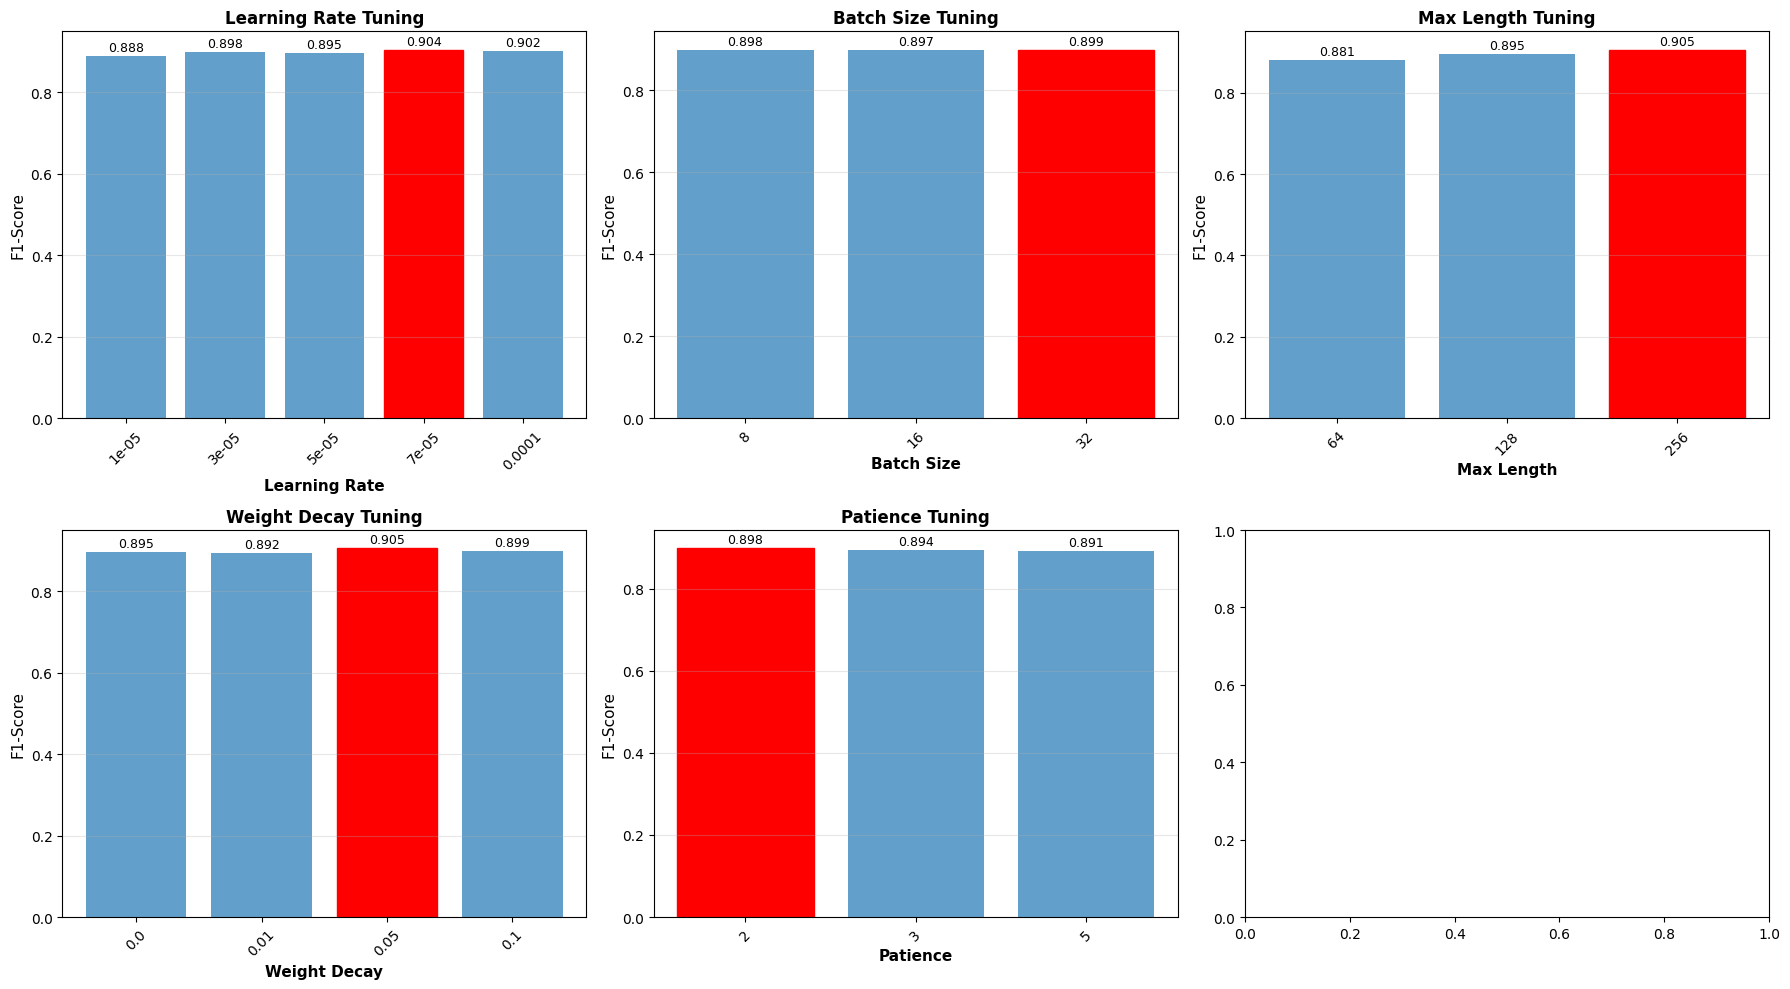

✅ Summary plot saved: distilbert_tuning_results/tuning_summary.png


In [12]:
# 9. VISUALISASI SUMMARY
print("\n📊 Creating summary visualizations...")

# Summary plot: Best value untuk setiap parameter
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (param_name, results) in enumerate(all_results.items()):
    ax = axes[idx]
    values = [r['value'] for r in results]
    f1_scores = [r['f1'] for r in results]
    
    bars = ax.bar(range(len(values)), f1_scores, alpha=0.7)
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(values, rotation=45)
    ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=11)
    ax.set_title(f'{param_name.replace("_", " ").title()} Tuning', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Highlight best
    best_idx = np.argmax(f1_scores)
    bars[best_idx].set_color('red')
    bars[best_idx].set_alpha(1.0)
    
    # Add value labels
    for i, (v, score) in enumerate(zip(values, f1_scores)):
        ax.text(i, score + 0.005, f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"{output_dir}/tuning_summary.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Summary plot saved: {output_dir}/tuning_summary.png")

In [13]:
# 10. COMPARISON TABLE
comparison_data = []
for param_name, results in all_results.items():
    best_result = max(results, key=lambda x: x['f1'])
    comparison_data.append({
        'Parameter': param_name,
        'Best Value': best_result['value'],
        'F1-Score': best_result['f1'],
        'Accuracy': best_result['accuracy'],
        'Precision': best_result['precision'],
        'Recall': best_result['recall']
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n📋 BEST VALUES PER PARAMETER:")
print(df_comparison.to_string(index=False))

# Save comparison table
df_comparison.to_csv(f"{output_dir}/comparison_table.csv", index=False)
print(f"\n✅ Comparison table saved: {output_dir}/comparison_table.csv")

print("\n" + "="*70)
print("✅ HYPERPARAMETER TUNING SELESAI!")
print("="*70)
print(f"\n📁 Semua hasil tersimpan di: {output_dir}/")
print(f"  • Model terbaik: {model_save_path}")
print(f"  • Visualisasi: {output_dir}/*.png")
print(f"  • Metadata: {output_dir}/metadata.json")
print(f"  • Tag mapping: {output_dir}/tag2idx.pkl")
print(f"  • Tuning results: {output_dir}/tuning_results.pkl")


📋 BEST VALUES PER PARAMETER:
    Parameter  Best Value  F1-Score  Accuracy  Precision   Recall
learning_rate     0.00007  0.903677  0.972210   0.909001 0.898415
   batch_size    32.00000  0.898581  0.970056   0.880519 0.917401
   max_length   256.00000  0.905117  0.973649   0.910892 0.899416
 weight_decay     0.05000  0.904565  0.972475   0.900572 0.908593
     patience     2.00000  0.898034  0.970463   0.884564 0.911920

✅ Comparison table saved: distilbert_tuning_results/comparison_table.csv

✅ HYPERPARAMETER TUNING SELESAI!

📁 Semua hasil tersimpan di: distilbert_tuning_results/
  • Model terbaik: distilbert_tuning_results/best_distilbert_model
  • Visualisasi: distilbert_tuning_results/*.png
  • Metadata: distilbert_tuning_results/metadata.json
  • Tag mapping: distilbert_tuning_results/tag2idx.pkl
  • Tuning results: distilbert_tuning_results/tuning_results.pkl
